Source: http://srome.github.io/Eigenvesting-IV-Predicting-Stock-And-Portfolio-Returns-With-Bayesian-Statistics/

In [3]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import datetime as dt
from pandas.io.data import DataReader
import matplotlib.pyplot as plt
import pymc3 as pm

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
np.random.seed(42) 
    
start, end = dt.datetime(2014, 1, 1), dt.datetime(2015, 12, 31)
sp500 = DataReader('^GSPC','yahoo', start, end).loc[:,'Close']

train, test = np.arange(0, 450), np.arange(451, len(sp500))
n=len(train)

returns = np.log(sp500[1:] / sp500[0:-1].values) # Calculate log returns
plt.plot(returns);

OSError: after 3 tries, Yahoo! did not return a 200 for url 'http://ichart.finance.yahoo.com/table.csv?s=^GSPC&a=0&b=1&c=2014&d=11&e=31&f=2015&g=d&ignore=.csv'

In [7]:
with pm.Model() as model:
    sigma = pm.Exponential('sigma', 1./.02, testval=.1)
    mu = pm.Normal('mu', 0, sd=5, testval=.1)

    nu = pm.Exponential('nu', 1./10)
    logs = pm.GaussianRandomWalk('logs', tau=sigma**-2, shape=n)

    #lam uses variance in pymc3, not sd like in scipy
    r = pm.StudentT('r', nu, mu=mu, lam=1/pm.exp(-2*logs), observed=returns.values[train]) 

Applied log-transform to sigma and added transformed sigma_log_ to model.
Applied log-transform to nu and added transformed nu_log_ to model.


In [8]:
with model:
    start = pm.find_MAP(vars=[logs], fmin=sp.optimize.fmin_l_bfgs_b)

with model:
    step = pm.NUTS(vars=[logs, mu, nu,sigma],scaling=start, gamma=.25)
    start2 = pm.sample(100, step, start=start)[-1]

    # Start next run at the last sampled position.
    step = pm.NUTS(vars=[logs, mu, nu,sigma],scaling=start2, gamma=.55)
    trace = pm.sample(2000, step, start=start2)

 [-----------------100%-----------------] 2000 of 2000 complete in 91.2 sec

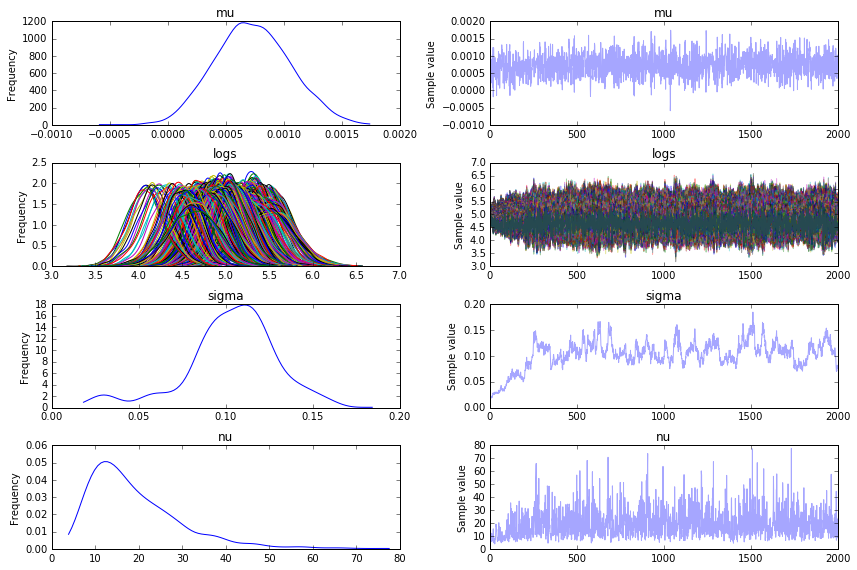

In [29]:
pm.traceplot(trace);

In [44]:
sigma = np.median(trace[:]['sigma'])
nu = np.median(trace[:]['sigma'])
mu = np.median(trace[:]['mu'])

In [43]:
trace[10]

{'logs': array([ 5.03303406,  4.97179032,  4.9727241 ,  4.98516375,  4.97898937,
         4.97242842,  4.95942656,  4.92259887,  4.91768439,  4.9064669 ,
         4.88711517,  4.88136945,  4.85577955,  4.8749341 ,  4.87784787,
         4.90653823,  4.8979282 ,  4.90303609,  4.87794029,  4.87274328,
         4.85276292,  4.86166451,  4.82293497,  4.82727825,  4.80325845,
         4.85518866,  4.87213711,  4.86840334,  4.87673948,  4.91701159,
         4.95827098,  4.96290378,  4.99225462,  5.00860694,  4.98096793,
         4.98491436,  5.01370982,  5.01964596,  5.00086197,  5.014875  ,
         5.03957046,  5.05340324,  5.05691824,  5.06337051,  5.08267186,
         5.05013346,  5.06114733,  5.07639838,  5.07163463,  5.03377943,
         5.02617104,  5.04775266,  5.04136234,  5.04731932,  5.06055736,
         5.056226  ,  5.03977533,  5.02722495,  5.06816055,  5.08443652,
         5.07089205,  5.07554976,  5.07265958,  5.05584189,  5.08774681,
         5.06415324,  5.05605348,  5.049142

In [34]:
trace[1]['logs']

array([ 5.00286388,  5.00185763,  5.01226265,  5.03354345,  5.03858206,
        5.01536328,  5.03916257,  5.03986485,  5.0501421 ,  5.063882  ,
        5.02549857,  5.04443285,  5.04324433,  5.0507519 ,  5.01893664,
        5.0585372 ,  5.02908668,  5.03195752,  5.07103315,  5.04455287,
        5.06627232,  5.07243904,  5.05479003,  5.04884699,  5.03849942,
        5.00968879,  4.99688864,  4.9691421 ,  4.91400794,  4.91209021,
        4.90495736,  4.87723685,  4.84279095,  4.86015308,  4.88701018,
        4.88584522,  4.86843149,  4.85472308,  4.86802136,  4.8582801 ,
        4.87562484,  4.88112182,  4.87352851,  4.88993196,  4.90033384,
        4.92678176,  4.9348644 ,  4.96270315,  4.97710002,  4.99797195,
        5.01488356,  5.03116032,  5.05084268,  5.06165568,  5.07255821,
        5.05245822,  5.05802752,  5.03894764,  5.05252124,  5.05518599,
        5.04628506,  5.02177165,  5.00399231,  4.96689532,  4.96553526,
        4.97552268,  4.98600426,  4.9961961 ,  5.01644224,  5.00

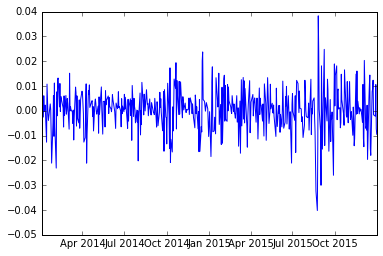

In [17]:
plt.plot(returns)
#plt.plot(1+len(train)+np.arange(0,len(test)), returns[1,:], color='r')

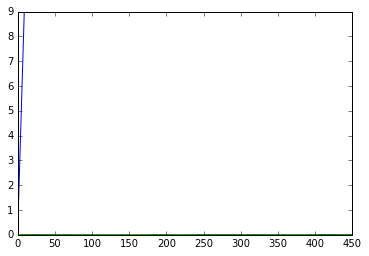

In [59]:
plt.plot(np.arange(10))
a = 1/np.exp(trace[k]['logs'])
plt.plot(a)

In [60]:
[plt.plot(1/np.exp(trace[k]['logs']),color='r',alpha=.2) for k in range(1000,len(trace))]
plt.plot(returns)
#plt.plot(1+len(train)+np.arange(0,len(test)),1/np.exp(vol[j,:]), alpha=.01, color='y') for j in range(0,1000)]
#ax = plt.gca()
#ax.set_ylim([-.05,.05])

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x113dad158> (for post_execute):


ValueError: ordinal must be >= 1

ValueError: ordinal must be >= 1

In [46]:
def generate_proj_returns(burn_in, trace, len_to_train):
    num_pred = 1000
    mod_returns = np.ones(shape = (num_pred,len_to_train))
    vol = np.ones(shape = (num_pred,len_to_train))
    for k in range(0,num_pred):
        nu = trace[burn_in+k]['nu']
        mu = trace[burn_in+k]['mu']
        sigma = trace[burn_in+k]['sigma']
        s = trace[burn_in+k]['logs'][-1]        
        for j in range(0,len_to_train):
            cur_log_return, s = _generate_proj_returns( mu,
                                                        s, 
                                                        nu,
                                                        sigma)
            mod_returns[k,j] = cur_log_return
            vol[k,j] = s
    return mod_returns, vol

def _generate_proj_returns(mu,volatility, nu, sig):
    next_vol = np.random.normal(volatility, scale=sig) #sig is SD

    # Not 1/np.exp(-2*next_vol), scale treated differently in scipy than pymc3
    log_return = stats.t.rvs(nu, mu, scale=np.exp(-1*next_vol))
    return log_return, next_vol

sim_returns, vol = generate_proj_returns(1000,trace,len(test))

In [47]:
#Convert simulated returns to log-price 
prices = np.copy(sim_returns)
for k in range(0, len(prices)):
    cur = np.log(sp500[test[0]])
    for j in range(0,len(prices[k])):
        cur = cur + prices[k, j]
        prices[k, j] = cur

(420, 502)

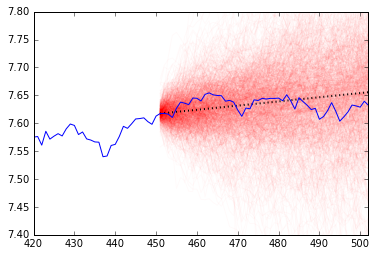

In [50]:
training_start = 420
slope = trace[1000:]['mu'].mean()
    
trend = np.arange(0,len(test))*slope

ind = np.arange(len(train)+1,1+len(train)+len(test))
ind2 = np.arange(training_start,1+len(train)+len(test))

[plt.plot(ind, prices[j,:], alpha=.02, color='r') for j in range(0,1000)]
plt.plot(ind, trend + np.log(sp500)[len(train)+1],
         alpha=1, 
         linewidth = 2, 
         color='black', 
         linestyle='dotted')

plt.plot(ind2,np.log(sp500)[ind2])

ax = plt.gca()
ax.set_ylim([7.4,7.8])
ax.set_xlim([training_start,len(sp500)-2])